# 3. Parallax errors

In [1]:
import os
import pathlib

import numpy as np
from scipy.interpolate import splrep, splev, BSpline
import pandas as pd

from astroquery.gaia import Gaia

import config

hpx_order=7 --> (hpx_nside=128, hpx_npix=196608)


In [2]:
cache_path = pathlib.Path(config.cache_path)
cache_path.mkdir(exist_ok=True)

fig_path = pathlib.Path(config.fig_path)
fig_path.mkdir(exist_ok=True)

## Query Gaia EDR3 `gaia_source' table

ADQL Coocbook: https://www.gaia.ac.uk/data/gaia-data-release-1/adql-cookbook

ADQL manual: https://www.ivoa.net/documents/ADQL/20180112/PR-ADQL-2.1-20180112.html

In [3]:
def query_plxerr_stats(num_stars):
    # The query is long, possibly need to login
    Gaia.login()

    query = \
    f"SELECT \
      source_id/{config.hpx_base} AS hpx, g_bin, \
      AVG(parallax_error) AS parallax_error, \
      AVG(visibility_periods_used) AS visibility_periods_used \
      FROM ( SELECT source_id, parallax_error, visibility_periods_used, \
             ((phot_g_mean_mag-{config.G_min})/{config.dG}) AS g_bin \
          FROM gaiadr3.gaia_source WHERE random_index < {num_stars}) AS subquery \
      GROUP BY hpx, g_bin \
    "

    job = Gaia.launch_job_async(query)
    return job.get_results().to_pandas()


In [4]:
file_name = cache_path / 'dr3_plxerr_stats.hdf5'

if os.path.exists(file_name):
    pe = pd.read_hdf(file_name, key='df')
else:
    pe = query_plxerr_stats(num_stars=10000000)
    # Save
    pe.to_hdf(file_name, key='df', format='table', data_columns=True, mode='w', index=False)

pe

,hpx,g_bin,parallax_error,visibility_periods_used
0,115097,90.431837,NaN,5.0
1,51930,93.920902,1.402338,11.0
2,51971,96.581129,NaN,7.0
3,62925,95.783810,2.076251,10.0
4,129137,72.139887,0.037037,23.0
...,...,...,...,...
9983129,193153,94.197821,0.916554,15.0
9983130,9024,96.154636,NaN,12.0
9983131,114811,91.732077,NaN,7.0
9983132,12966,92.579426,0.658761,15.0


In [5]:
pe.describe()

,hpx,g_bin,parallax_error,visibility_periods_used
count,9.983134e+06,9.968616e+06,8.096563e+06,9.983134e+06
mean,1.236445e+05,8.805558e+01,4.633512e-01,1.627032e+01
std,4.663376e+04,7.747745e+00,4.197207e-01,6.497347e+00
min,0.000000e+00,4.767463e+00,7.770088e-03,1.000000e+00
25%,1.147890e+05,8.457711e+01,1.553369e-01,1.200000e+01
50%,1.216710e+05,9.011402e+01,3.430443e-01,1.600000e+01
75%,1.665990e+05,9.375248e+01,6.418277e-01,2.100000e+01
max,1.966070e+05,1.043085e+02,5.097040e+00,3.300000e+01


In [6]:
# Clean
mask = (0 <= pe['g_bin']) & (pe['g_bin'] < len(config.G_bins))
pe = pe[mask].copy()
pe.dropna(inplace=True)

pe['g_bin'] = pe['g_bin'].astype(int)
len(pe)

8088435

# Some plots

In [7]:
# Read RGB stars catalogue
usecols = ['parallax_error', 'phot_g_mean_mag']
rgb = pd.read_hdf(cache_path / 'rgb.hdf5', key='rgb', usecols=usecols)

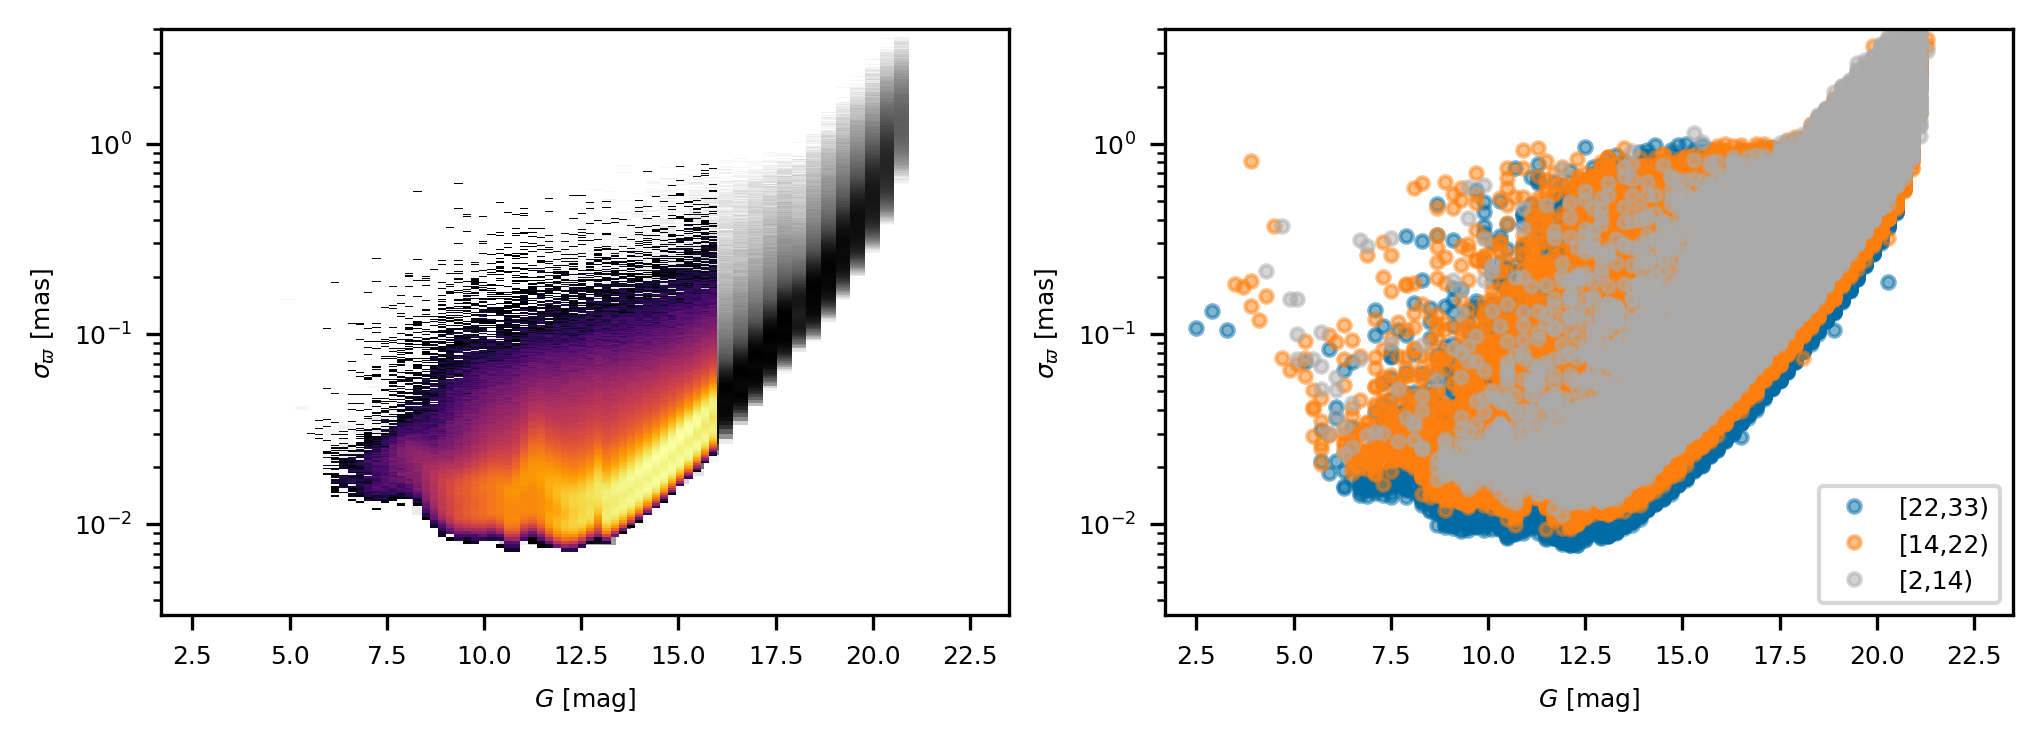

In [8]:
plt.rc('font', size=6.0)
inch = 2.54  ## cm
width, height = 17/inch, 6/inch
plt.figure(figsize=(width, height), layout='constrained', dpi=config.fig_dpi)
mpl.style.use('tableau-colorblind10')

plt.subplot(1, 2, 1)
plt.hist2d(config.G_bins[pe['g_bin']], pe['parallax_error'], bins=(50,3000), cmap='Greys', norm='log', rasterized=True)
plt.hist2d(rgb['phot_g_mean_mag'], rgb['parallax_error'], bins=(50,3000), cmap='inferno', norm='log', rasterized=True)
plt.xlabel(r"$G$ [mag]")
plt.xlim(config.G_bins[0], config.G_bins[-1])
plt.ylabel(r"$\sigma_\varpi$ [mas]")
plt.yscale('log')
plt.ylim(3.33e-3, 4.0)

plt.subplot(1, 2, 2)
nvis_edges = [2, 10, 15, 22, 33]
nvis_edges = [2, 14, 22, 33]
for n in range(len(nvis_edges)-1)[::-1]:
    nvis_lo, nvis_hi = nvis_edges[n], nvis_edges[n+1]
    mask = (nvis_lo <= pe['visibility_periods_used']) & (pe['visibility_periods_used'] < nvis_hi)
    pe_ = pe[mask]
    plt.plot(config.G_bins[pe_['g_bin']], pe_['parallax_error'], '.', alpha=0.5, label=f"[{nvis_lo},{nvis_hi})")
plt.legend(loc='lower right')
plt.xlabel(r"$G$ [mag]")
plt.xlim(config.G_bins[0], config.G_bins[-1])
plt.ylabel(r"$\sigma_\varpi$ [mas]")
plt.yscale('log')
plt.ylim(3.33e-3, 4.0)

plt.savefig(fig_path / 'data-plxerr.png')
plt.show()
plt.close()

In [9]:
del(rgb)

## Fit parallax errors by G given nvis

In [10]:
nvis_bins = [2, 14, 15, 16, 17, 19, 20, 24, 26, 27.5, 33]
pe['nvis_bin'] = pd.cut(pe['visibility_periods_used'], bins=nvis_bins)
gr = pe.groupby(['nvis_bin', 'g_bin'], observed=True).agg(plxerr=('parallax_error', 'median'))
gr.reset_index(inplace=True)

gr['nvis'] = gr['nvis_bin'].map(lambda x: 0.5*(x.left + x.right))
gr['g'] = 0.5*(config.G_bins[gr['g_bin']] + config.G_bins[gr['g_bin']+1])

In [11]:
def fit(G, plxerr):
    x = G
    y = np.log10(plxerr)
    s = len(x)
    tck = splrep(x, y, s=s)
    return tck

plxerr_nvis_g = {}

G_min = 8.0
G_max = config.G_bins.max()
G_bins_ = np.linspace(G_min, G_max, 17)

for bin, gr_ in gr.groupby('nvis_bin', observed=True):
    tck = fit(gr_['g'], gr_['plxerr'])
    plxerr_nvis_g[str(bin)] = {}
    plxerr_nvis_g[str(bin)]['G'] = G_bins_
    plxerr_nvis_g[str(bin)]['logsigma_plx'] = BSpline(*tck)(G_bins_)

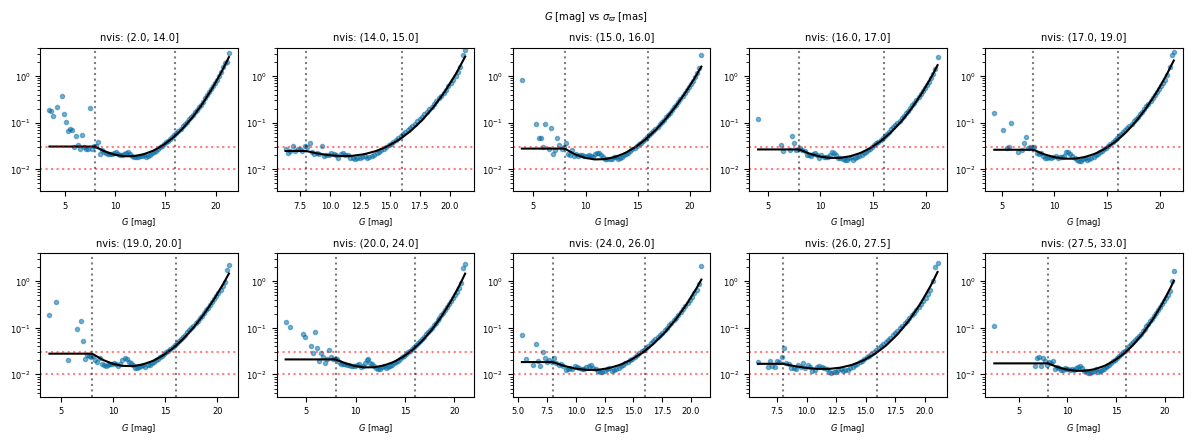

In [13]:
plt.rc('font', size=6.0)
inch = 2.54  ## cm
width, height = 30/inch, 11/inch
plt.figure(figsize=(width, height), layout='constrained')
plt.suptitle(r"$G$ [mag] vs $\sigma_\varpi$ [mas]")

i = 0
for bin, gr_ in gr.groupby('nvis_bin', observed=True):
    plt.subplot(2, 5, i+1)

    plt.title(f"nvis: {bin}")

    G = config.G_bins[gr_['g_bin']]
    plt.plot(G, gr_['plxerr'], ls='', marker='.', alpha=0.5)

    plt.plot(G, 10**np.interp(G, plxerr_nvis_g[str(bin)]['G'], plxerr_nvis_g[str(bin)]['logsigma_plx']), 'k')
    plt.axhline(3e-2, ls=':', c='r', alpha=0.5)
    plt.axhline(1e-2, ls=':', c='r', alpha=0.5)
    plt.axvline(8.0, ls=':', c='k', alpha=0.5)
    plt.axvline(16.0, ls=':', c='k', alpha=0.5)
    plt.xlabel(r"$G$ [mag]")
    plt.yscale('log')
    plt.ylim(3.33e-3, 4.0)

    i += 1

plt.savefig(fig_path / 'data-plxerr-fit.pdf')
plt.show()
plt.close()

# Save the parallax errors model

In [14]:
d = {}
d['nvis_bins'] = nvis_bins
d['plxerr_nvis_g']= plxerr_nvis_g
np.savez_compressed(cache_path / 'logplxerr_nvis_g.npz', **d)